<a href="https://www.kaggle.com/code/hoaian12042004/group5-all-models?scriptVersionId=204569266" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bank-account-fraud-dataset-neurips-2022/Base.csv
/kaggle/input/bank-account-fraud-dataset-neurips-2022/Variant IV.csv
/kaggle/input/bank-account-fraud-dataset-neurips-2022/Variant V.csv
/kaggle/input/bank-account-fraud-dataset-neurips-2022/Variant I.csv
/kaggle/input/bank-account-fraud-dataset-neurips-2022/Variant III.csv
/kaggle/input/bank-account-fraud-dataset-neurips-2022/Variant II.csv


### Import libraries

In [56]:
# Essential imports
import pandas as pd
import numpy as np
import time

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

# Data processing imports
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.utils import resample

# Model imports
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import xgboost as xgb  # Assuming xgboost is already installed
from sklearn.naive_bayes import *
from lightgbm import LGBMClassifier

# Handling imbalance
from imblearn.over_sampling import SMOTE

# Evaluation metric imports
from sklearn.metrics import (
    classification_report, 
    accuracy_score, 
    confusion_matrix, 
    roc_auc_score, 
    roc_curve, 
    log_loss, 
    mean_squared_error
)

# Explainability imports
import shap
from lime.lime_tabular import LimeTabularExplainer

In [3]:
pd.set_option('display.max_columns',None)
pd.set_option('display.max_colwidth',None)

### Data Understanding

In [4]:
df=pd.read_csv('/kaggle/input/bank-account-fraud-dataset-neurips-2022/Base.csv')

In [7]:
df.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,employment_status,credit_risk_score,email_is_free,housing_status,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0,0.3,0.986506,-1,25,40,0.006735,102.453711,AA,1059,13096.035018,7850.955007,6742.080561,5,5,CB,163,1,BC,0,1,9,0,1500.0,0,INTERNET,16.224843,linux,1,1,0,0
1,0,0.8,0.617426,-1,89,20,0.010095,-0.849551,AD,1658,9223.283431,5745.251481,5941.664859,3,18,CA,154,1,BC,1,1,2,0,1500.0,0,INTERNET,3.363854,other,1,1,0,0
2,0,0.8,0.996707,9,14,40,0.012316,-1.490386,AB,1095,4471.472149,5471.988958,5992.555113,15,11,CA,89,1,BC,0,1,30,0,200.0,0,INTERNET,22.730559,windows,0,1,0,0
3,0,0.6,0.475100,11,14,30,0.006991,-1.863101,AB,3483,14431.993621,6755.344479,5970.336831,11,13,CA,90,1,BC,0,1,1,0,200.0,0,INTERNET,15.215816,linux,1,1,0,0
4,0,0.9,0.842307,-1,29,40,5.742626,47.152498,AA,2339,7601.511579,5124.046930,5940.734212,1,6,CA,91,0,BC,1,1,26,0,200.0,0,INTERNET,3.743048,other,0,1,0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 32 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   fraud_bool                        1000000 non-null  int64  
 1   income                            1000000 non-null  float64
 2   name_email_similarity             1000000 non-null  float64
 3   prev_address_months_count         1000000 non-null  int64  
 4   current_address_months_count      1000000 non-null  int64  
 5   customer_age                      1000000 non-null  int64  
 6   days_since_request                1000000 non-null  float64
 7   intended_balcon_amount            1000000 non-null  float64
 8   payment_type                      1000000 non-null  object 
 9   zip_count_4w                      1000000 non-null  int64  
 10  velocity_6h                       1000000 non-null  float64
 11  velocity_24h                      1000

In [8]:
df.duplicated().sum()

0

In [9]:
df.describe()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,email_is_free,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1.000000e+06,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.0,1000000.000000
mean,0.011029,0.562696,0.493694,16.718568,86.587867,33.689080,1.025705e+00,8.661499,1572.692049,5665.296605,4769.781965,4856.324016,184.361849,9.503544,130.989595,0.529886,0.417077,0.889676,10.839303,0.222988,515.851010,0.025242,7.544940,0.576947,1.018312,0.0,3.288674
std,0.104438,0.290343,0.289125,44.046230,88.406599,12.025799,5.381835e+00,20.236155,1005.374565,3009.380665,1479.212612,919.843934,459.625329,5.033792,69.681812,0.499106,0.493076,0.313293,12.116875,0.416251,487.559902,0.156859,8.033106,0.494044,0.180761,0.0,2.209994
min,0.000000,0.100000,0.000001,-1.000000,-1.000000,10.000000,4.036860e-09,-15.530555,1.000000,-170.603072,1300.307314,2825.748405,0.000000,0.000000,-170.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,190.000000,0.000000,-1.000000,0.000000,-1.000000,0.0,0.000000
25%,0.000000,0.300000,0.225216,-1.000000,19.000000,20.000000,7.193246e-03,-1.181488,894.000000,3436.365848,3593.179135,4268.368423,1.000000,6.000000,83.000000,0.000000,0.000000,1.000000,-1.000000,0.000000,200.000000,0.000000,3.103053,0.000000,1.000000,0.0,1.000000
50%,0.000000,0.600000,0.492153,-1.000000,52.000000,30.000000,1.517574e-02,-0.830507,1263.000000,5319.769349,4749.921161,4913.436941,9.000000,9.000000,122.000000,1.000000,0.000000,1.000000,5.000000,0.000000,200.000000,0.000000,5.114321,1.000000,1.000000,0.0,3.000000
75%,0.000000,0.800000,0.755567,12.000000,130.000000,40.000000,2.633069e-02,4.984176,1944.000000,7680.717827,5752.574191,5488.083356,25.000000,13.000000,178.000000,1.000000,1.000000,1.000000,25.000000,0.000000,500.000000,0.000000,8.866131,1.000000,1.000000,0.0,5.000000
max,1.000000,0.900000,0.999999,383.000000,428.000000,90.000000,7.845690e+01,112.956928,6700.000000,16715.565404,9506.896596,6994.764201,2385.000000,39.000000,389.000000,1.000000,1.000000,1.000000,32.000000,1.000000,2100.000000,1.000000,85.899143,1.000000,2.000000,0.0,7.000000


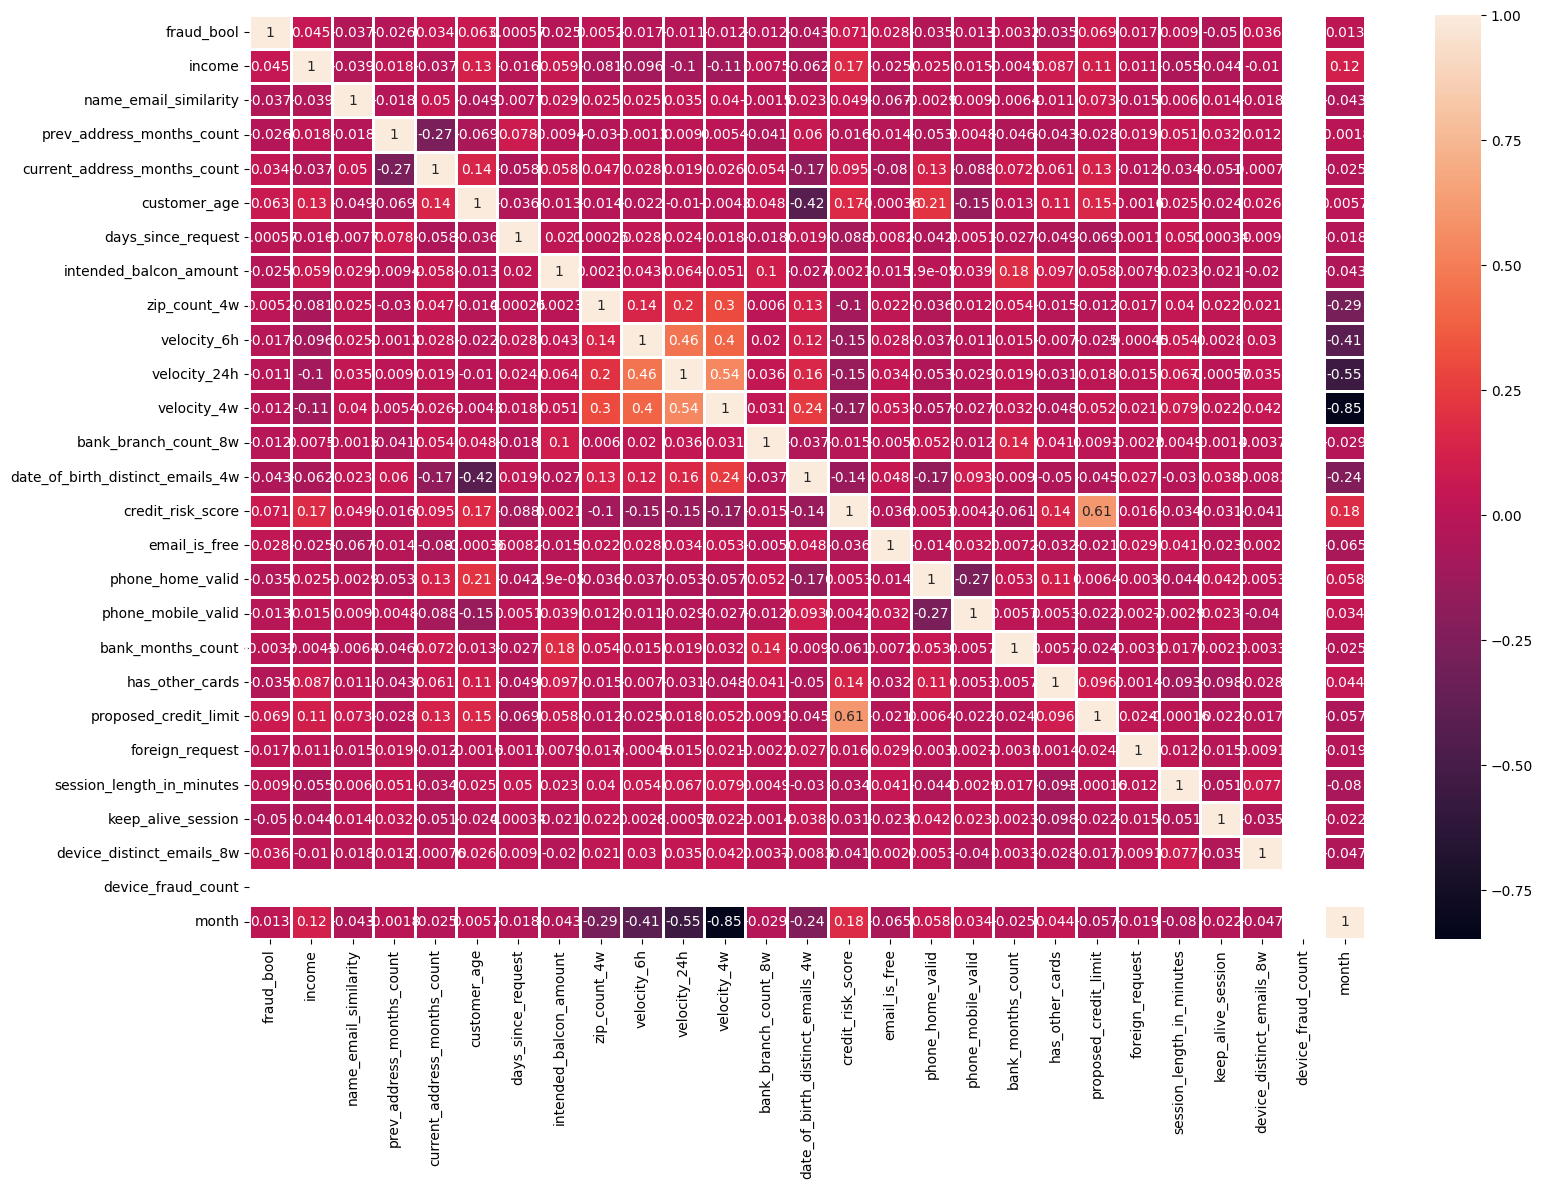

In [10]:
plt.figure(figsize = (18, 12))

# Calculate correlation matrix only for numeric columns
corr = df.corr(numeric_only=True)

sns.heatmap(data = corr, annot = True, fmt = '.2g', linewidth = 1)
plt.show()

fraud_bool
0    988971
1     11029
Name: count, dtype: int64
fraud_bool
0    0.988971
1    0.011029
Name: proportion, dtype: float64


Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

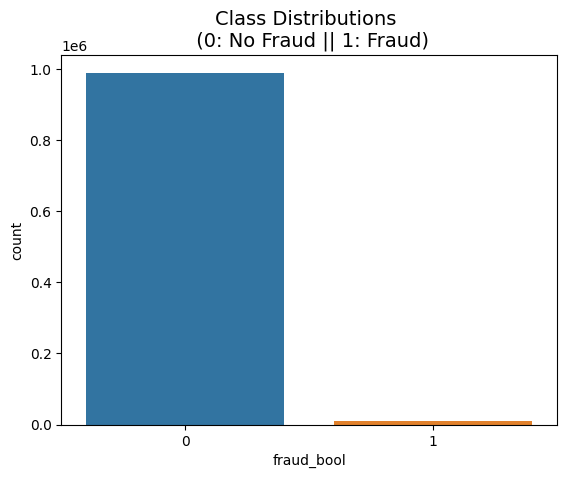

In [11]:
print(df.fraud_bool.value_counts(normalize=False))
print(df.fraud_bool.value_counts(normalize=True))
sns.countplot(x='fraud_bool', data=df)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

In [12]:
cat_df = df.select_dtypes(include = ['object'])

In [13]:
for col in cat_df.columns:
    print(f"Column: {col}")
    print(f"Unique Values: {cat_df[col].unique()}")
    print("Value Counts:")
    print(cat_df[col].value_counts(dropna=False))
    print("-" * 40)  # Line separator for readability

Column: payment_type
Unique Values: ['AA' 'AD' 'AB' 'AC' 'AE']
Value Counts:
payment_type
AB    370554
AA    258249
AC    252071
AD    118837
AE       289
Name: count, dtype: int64
----------------------------------------
Column: employment_status
Unique Values: ['CB' 'CA' 'CC' 'CF' 'CD' 'CE' 'CG']
Value Counts:
employment_status
CA    730252
CB    138288
CF     44034
CC     37758
CD     26522
CE     22693
CG       453
Name: count, dtype: int64
----------------------------------------
Column: housing_status
Unique Values: ['BC' 'BE' 'BD' 'BA' 'BB' 'BF' 'BG']
Value Counts:
housing_status
BC    372143
BB    260965
BA    169675
BE    169135
BD     26161
BF      1669
BG       252
Name: count, dtype: int64
----------------------------------------
Column: source
Unique Values: ['INTERNET' 'TELEAPP']
Value Counts:
source
INTERNET    992952
TELEAPP       7048
Name: count, dtype: int64
----------------------------------------
Column: device_os
Unique Values: ['linux' 'other' 'windows' 'x11' 'ma

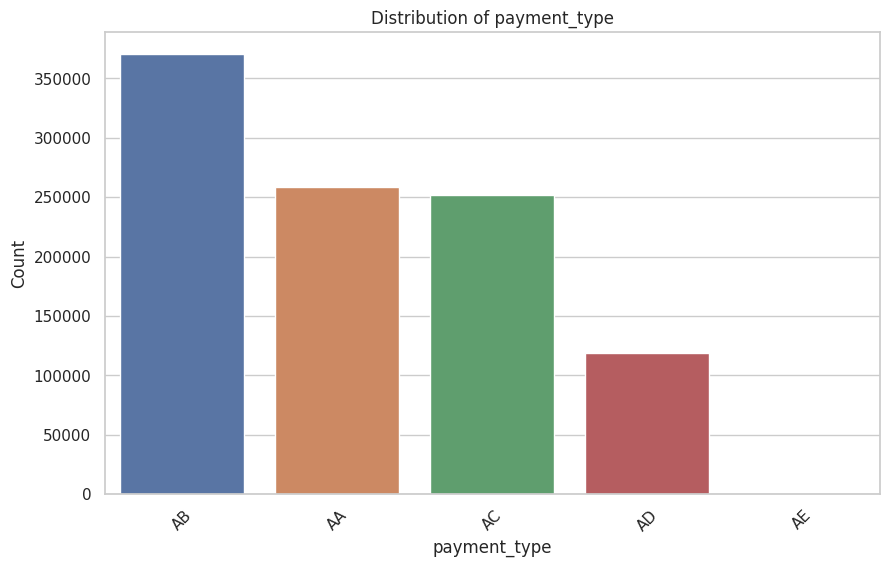

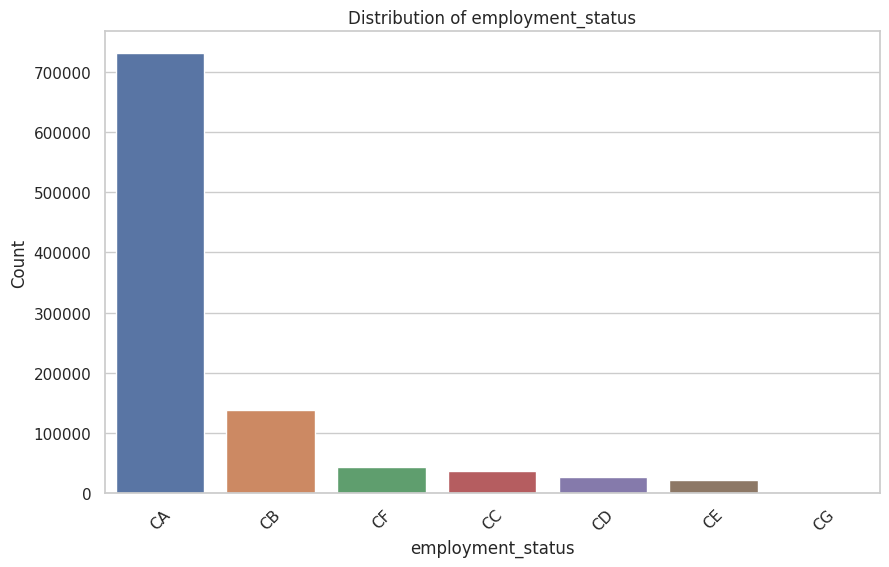

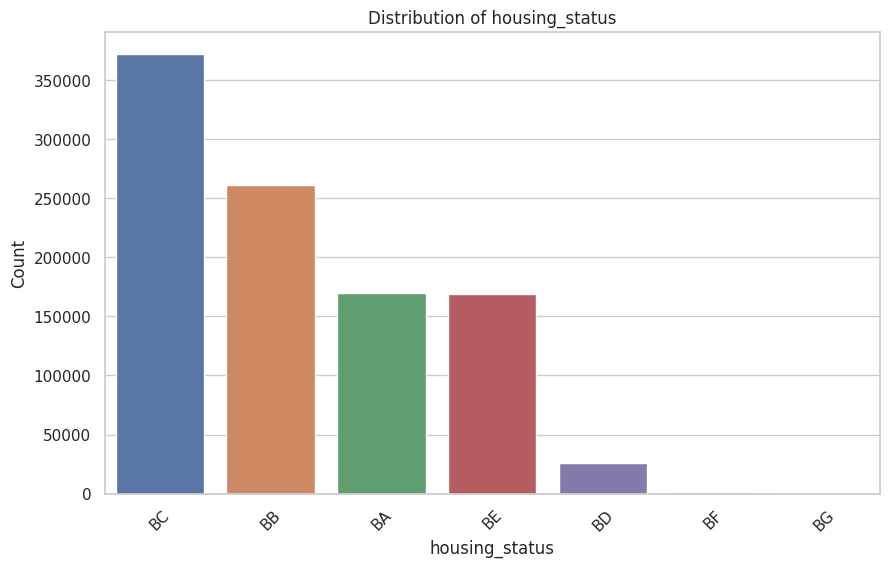

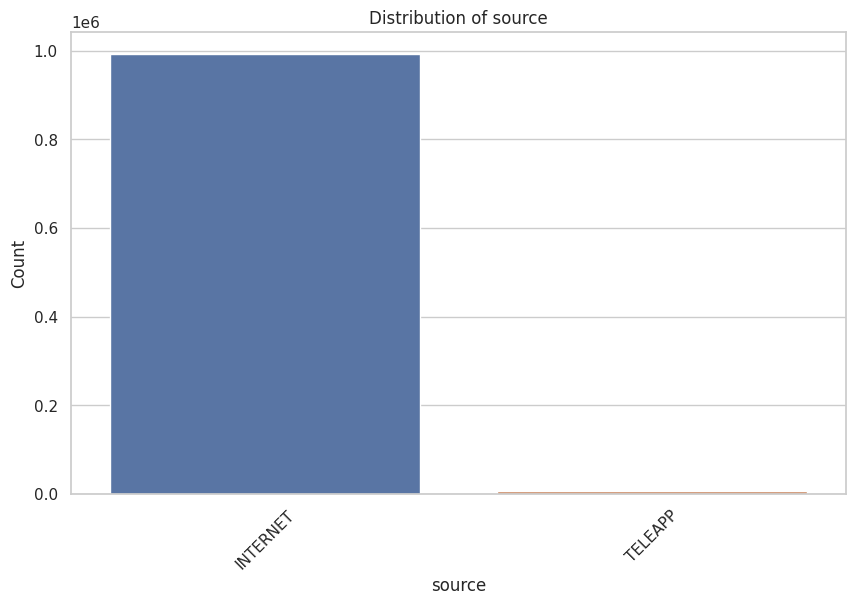

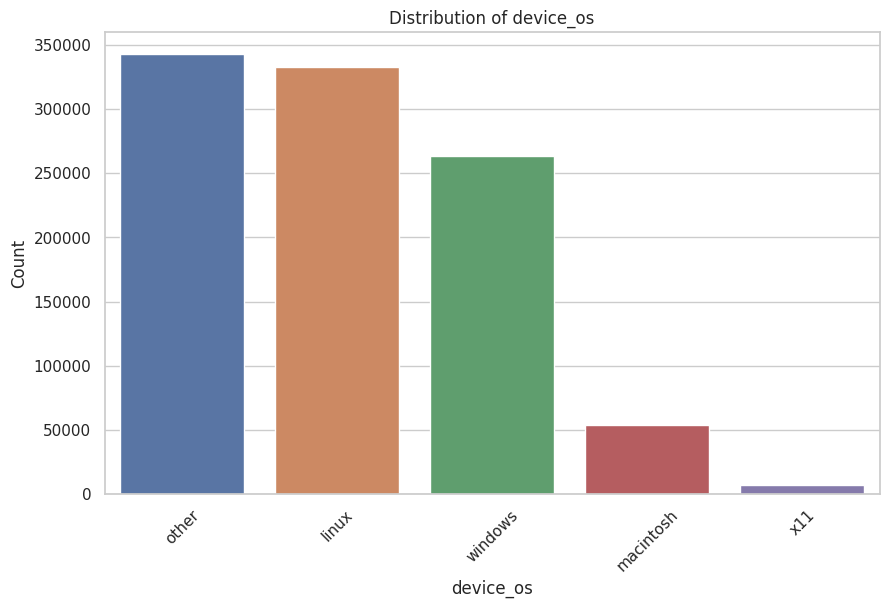

In [14]:
sns.set(style="whitegrid")

# Iterate through each column in the categorical DataFrame
for col in cat_df.columns:
    # Set up the figure for each chart
    plt.figure(figsize=(10, 6))
    
    # Plot the value counts as a bar chart
    sns.countplot(data=cat_df, x=col, order=cat_df[col].value_counts().index)
    
    # Add title and labels
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    
    # Rotate x-axis labels if they are too long
    plt.xticks(rotation=45)
    
    # Show plot
    plt.show()

In [15]:
num_df = df.select_dtypes(exclude = ['object'])

In [18]:
num_df.columns

Index(['fraud_bool', 'income', 'name_email_similarity',
       'prev_address_months_count', 'current_address_months_count',
       'customer_age', 'days_since_request', 'intended_balcon_amount',
       'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w',
       'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w',
       'credit_risk_score', 'email_is_free', 'phone_home_valid',
       'phone_mobile_valid', 'bank_months_count', 'has_other_cards',
       'proposed_credit_limit', 'foreign_request', 'session_length_in_minutes',
       'keep_alive_session', 'device_distinct_emails_8w', 'device_fraud_count',
       'month'],
      dtype='object')

In [20]:
num_df.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,email_is_free,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0,0.3,0.986506,-1,25,40,0.006735,102.453711,1059,13096.035018,7850.955007,6742.080561,5,5,163,1,0,1,9,0,1500.0,0,16.224843,1,1,0,0
1,0,0.8,0.617426,-1,89,20,0.010095,-0.849551,1658,9223.283431,5745.251481,5941.664859,3,18,154,1,1,1,2,0,1500.0,0,3.363854,1,1,0,0
2,0,0.8,0.996707,9,14,40,0.012316,-1.490386,1095,4471.472149,5471.988958,5992.555113,15,11,89,1,0,1,30,0,200.0,0,22.730559,0,1,0,0
3,0,0.6,0.475100,11,14,30,0.006991,-1.863101,3483,14431.993621,6755.344479,5970.336831,11,13,90,1,0,1,1,0,200.0,0,15.215816,1,1,0,0
4,0,0.9,0.842307,-1,29,40,5.742626,47.152498,2339,7601.511579,5124.046930,5940.734212,1,6,91,0,1,1,26,0,200.0,0,3.743048,0,1,0,0


<Figure size 1000x600 with 0 Axes>

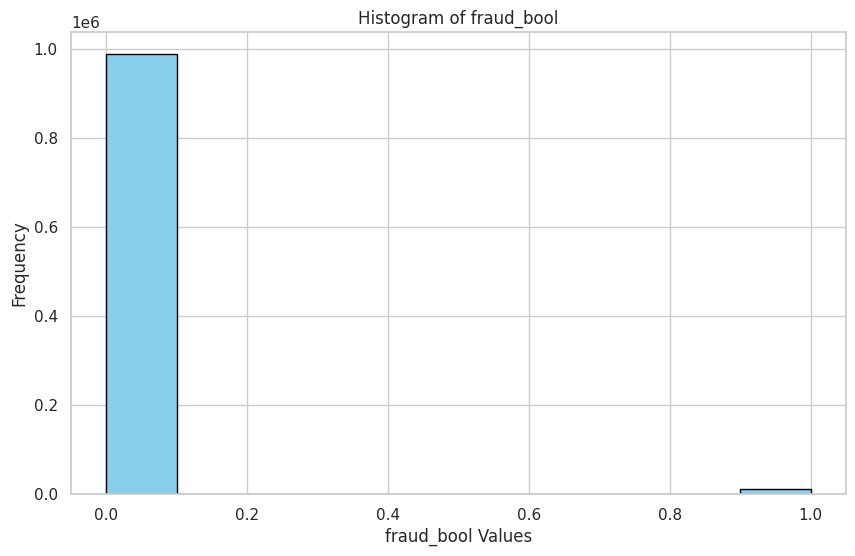

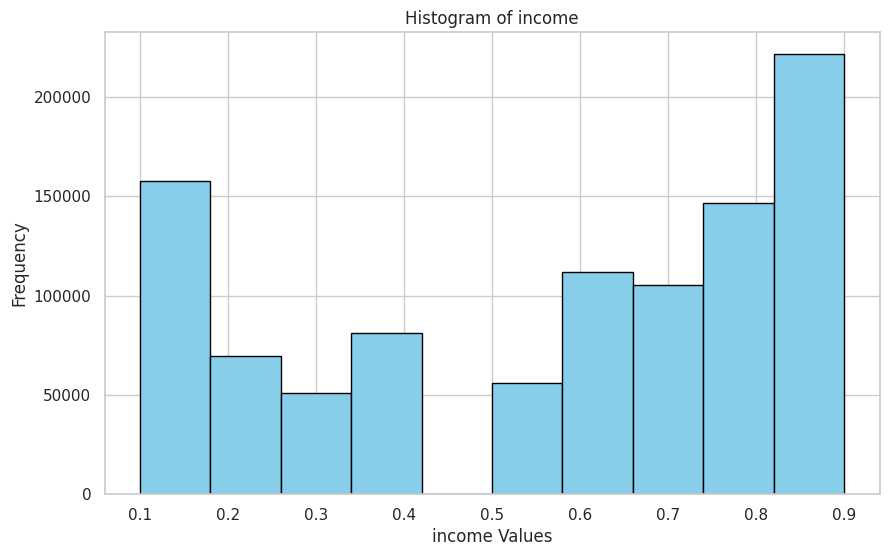

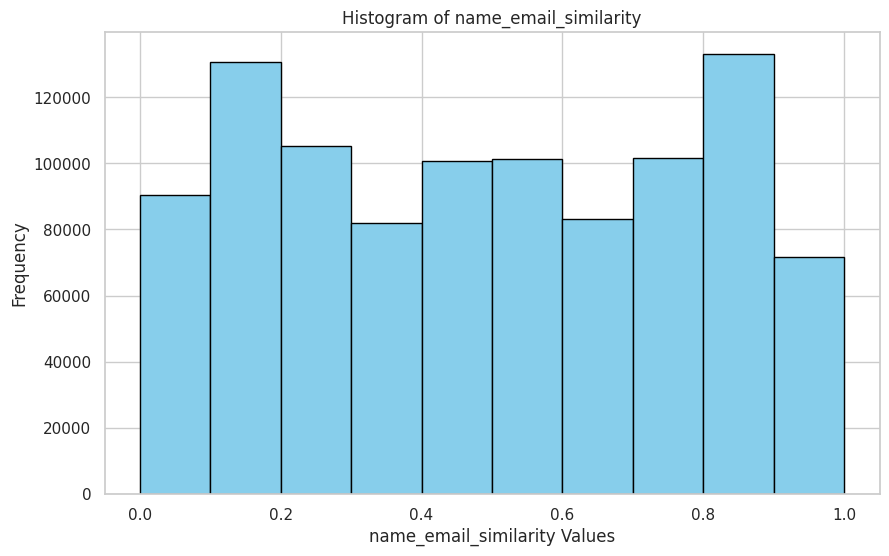

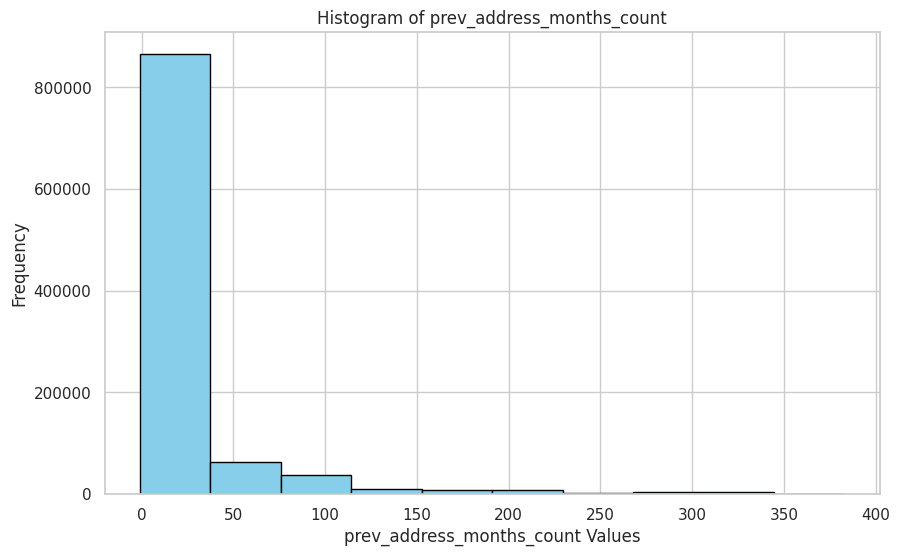

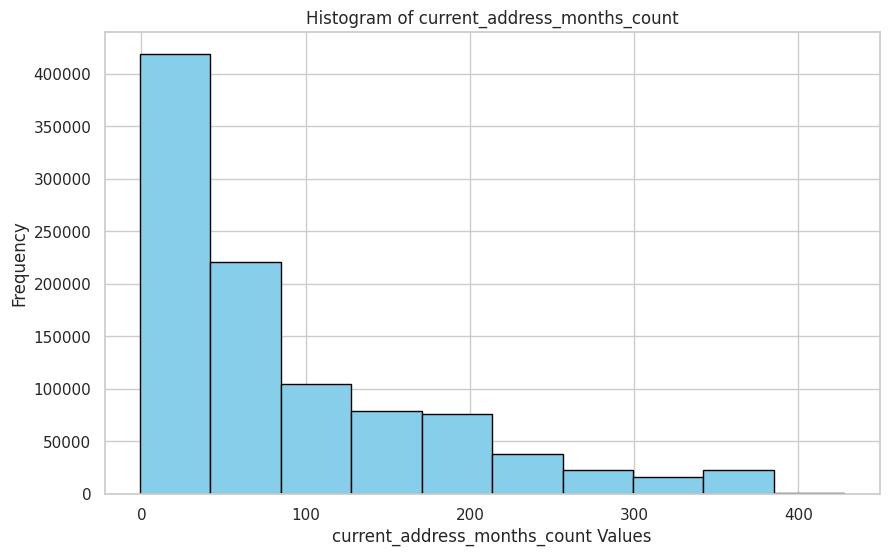

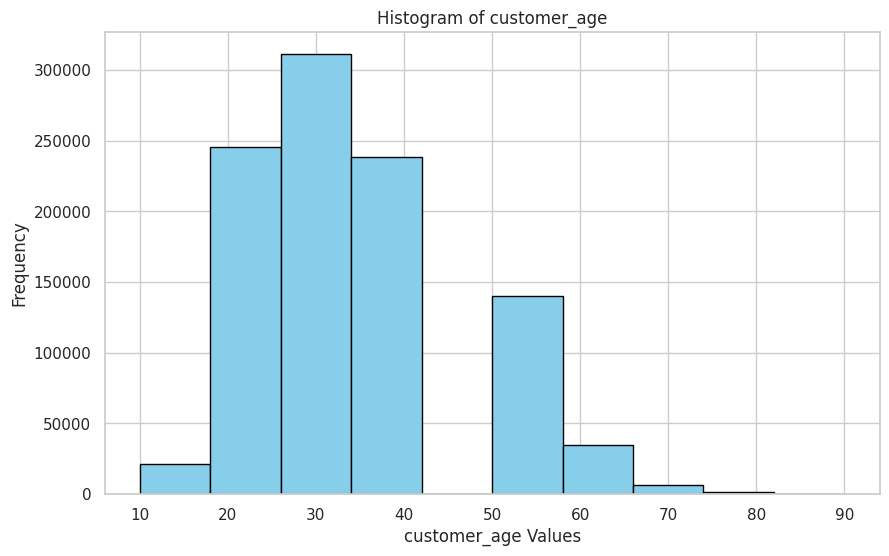

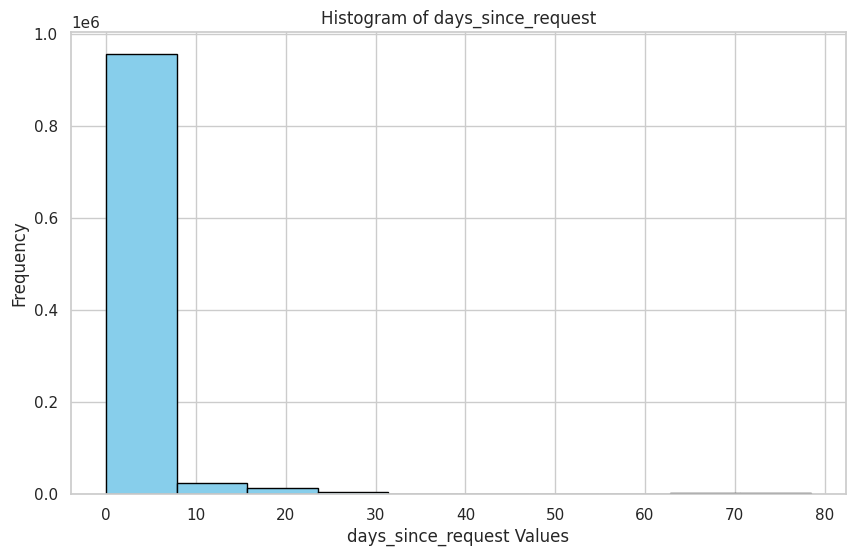

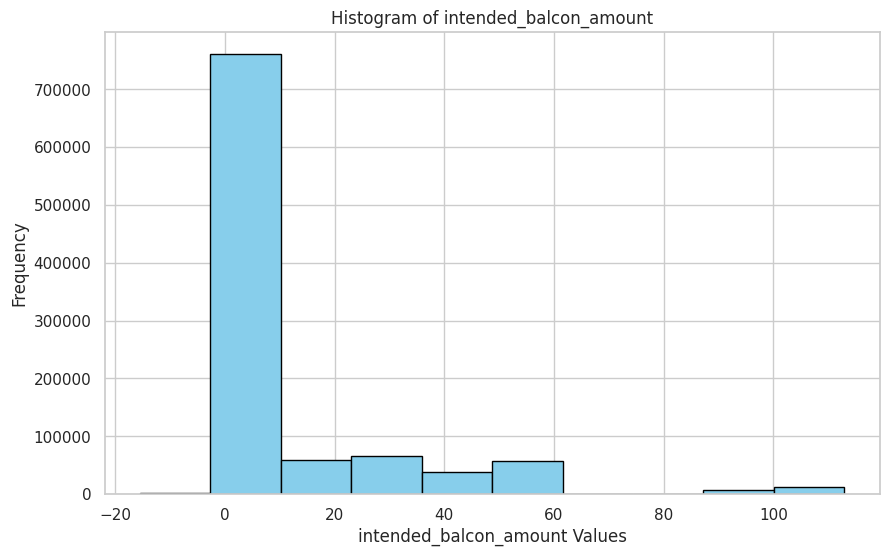

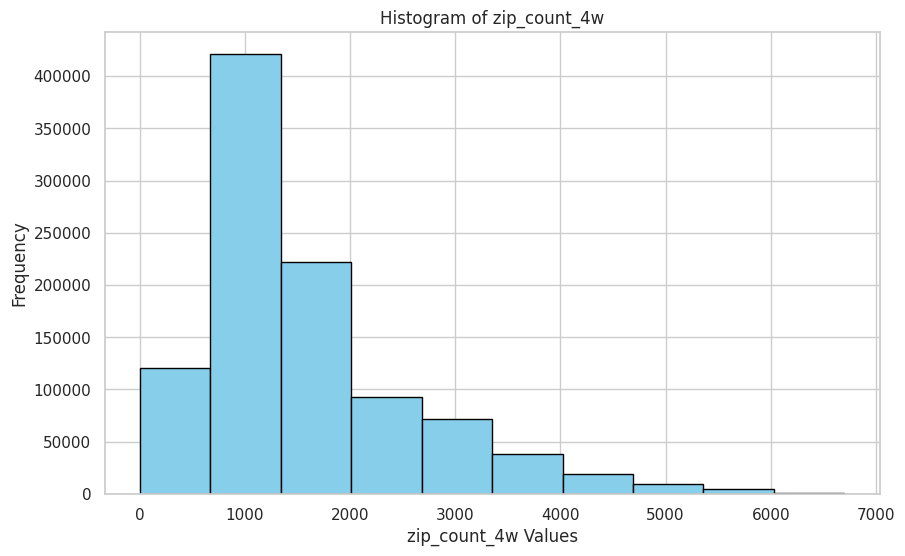

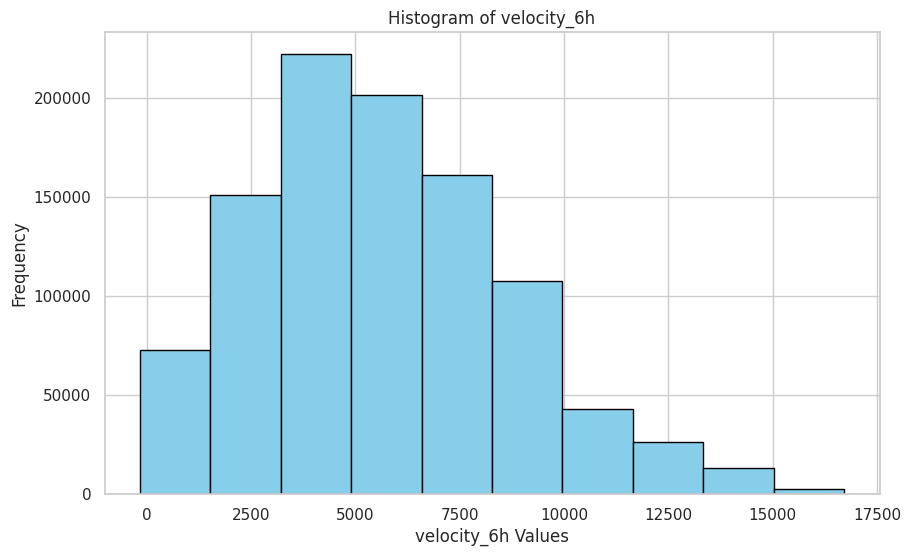

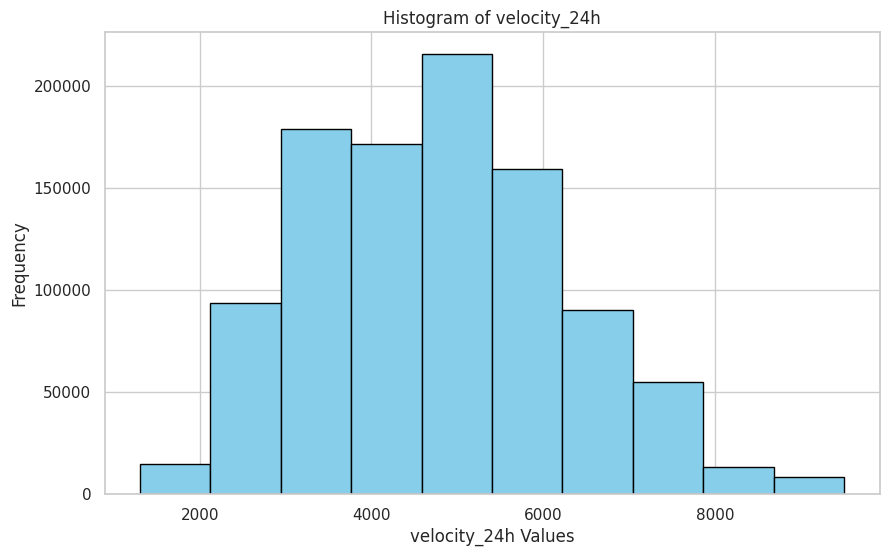

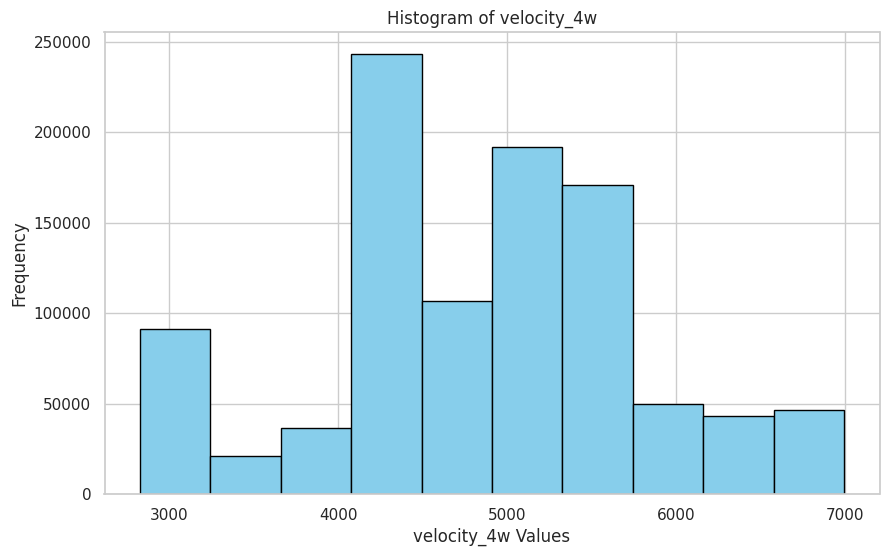

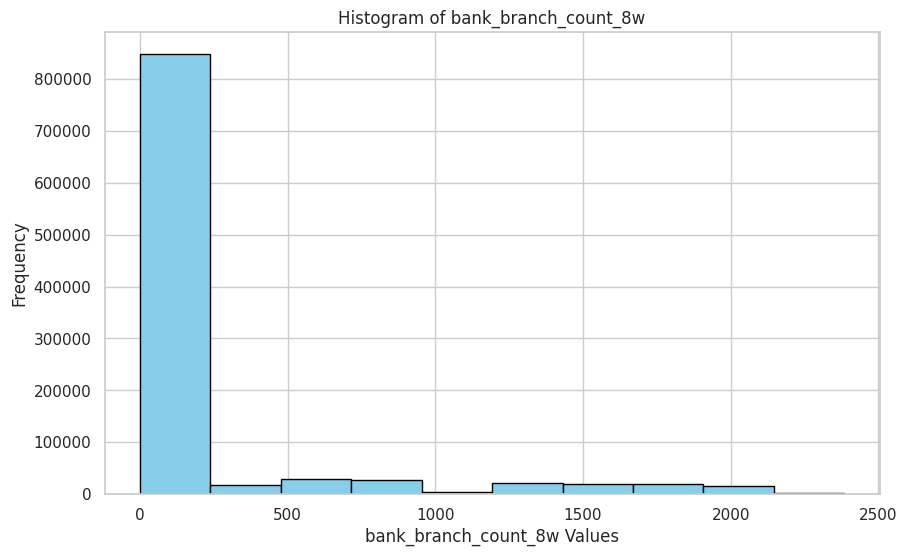

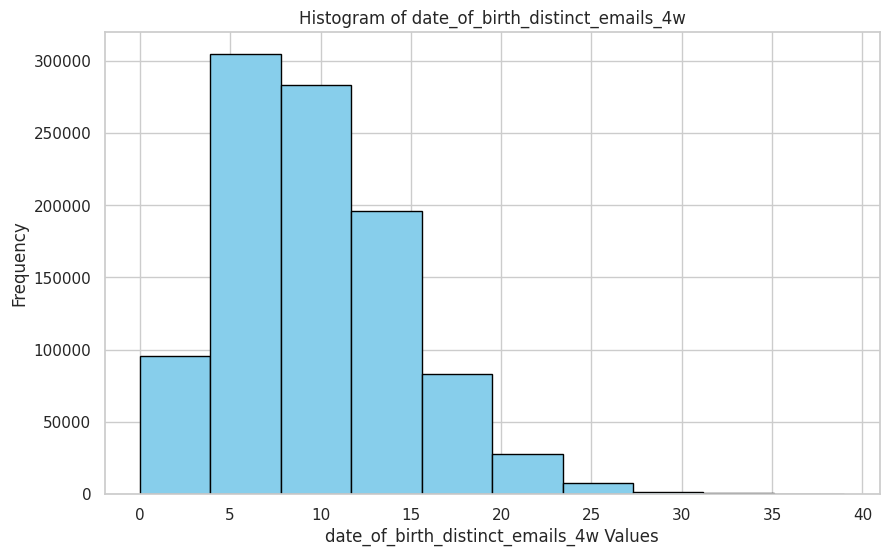

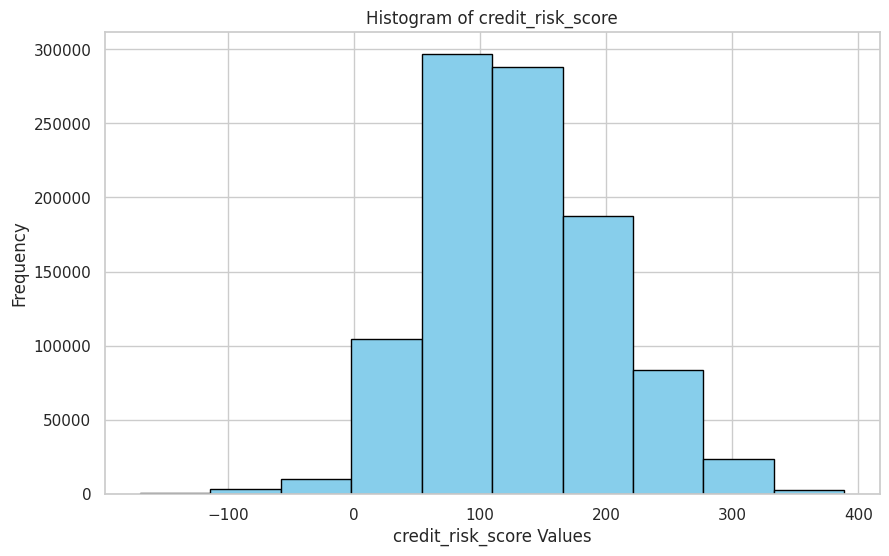

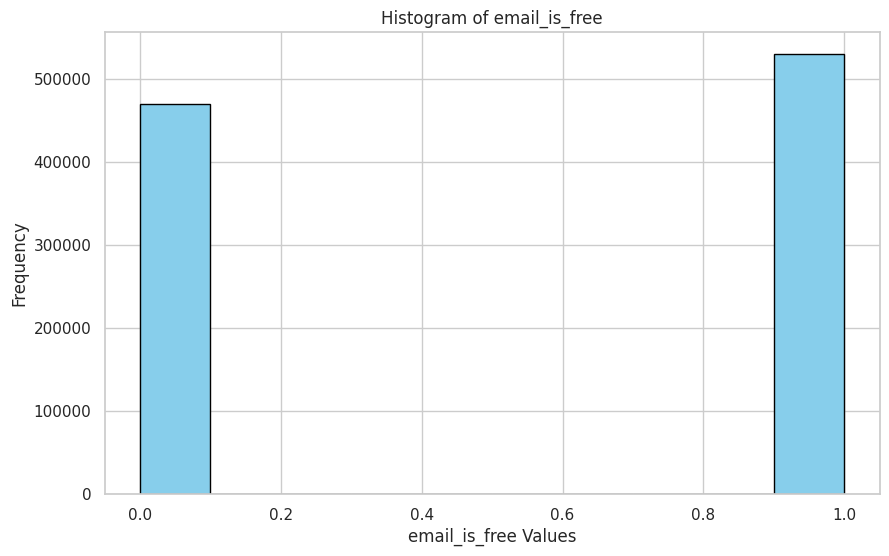

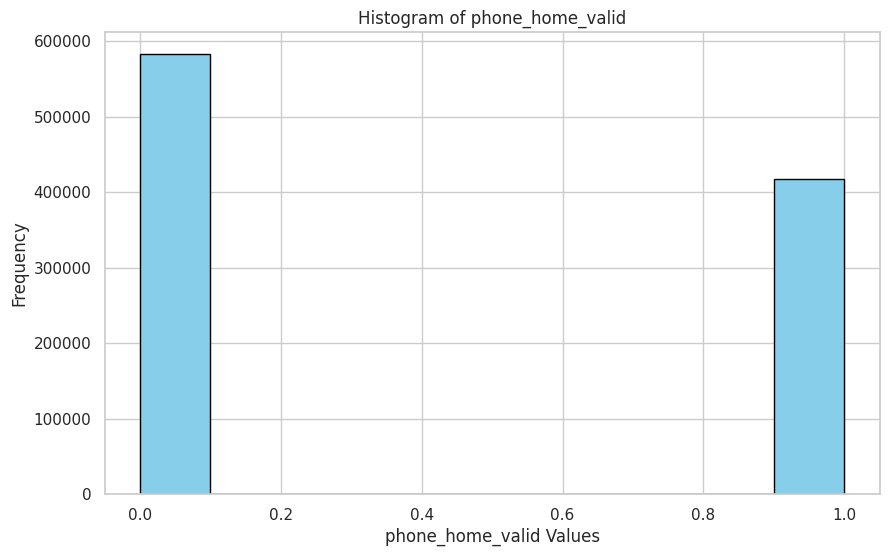

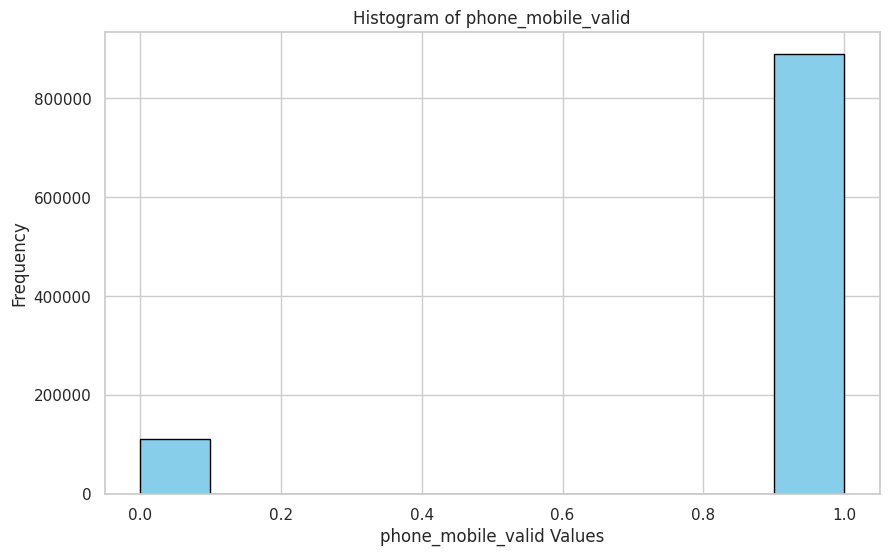

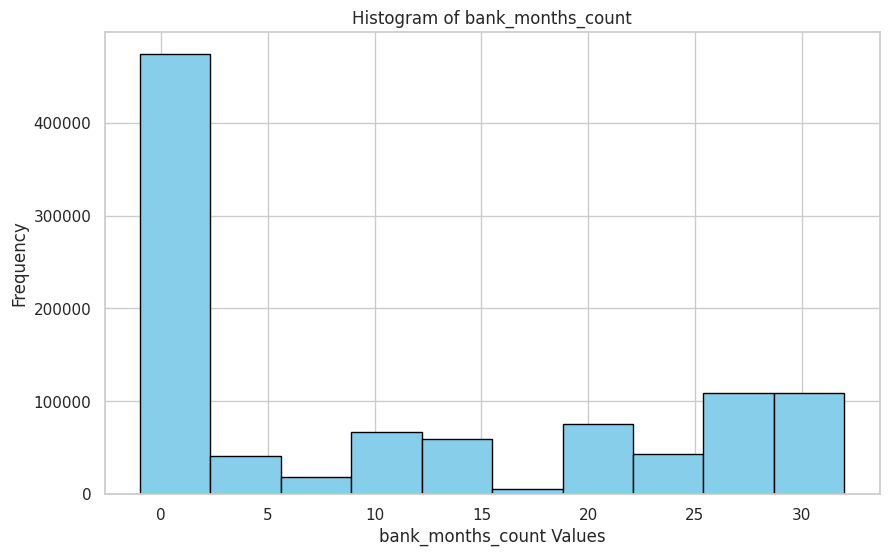

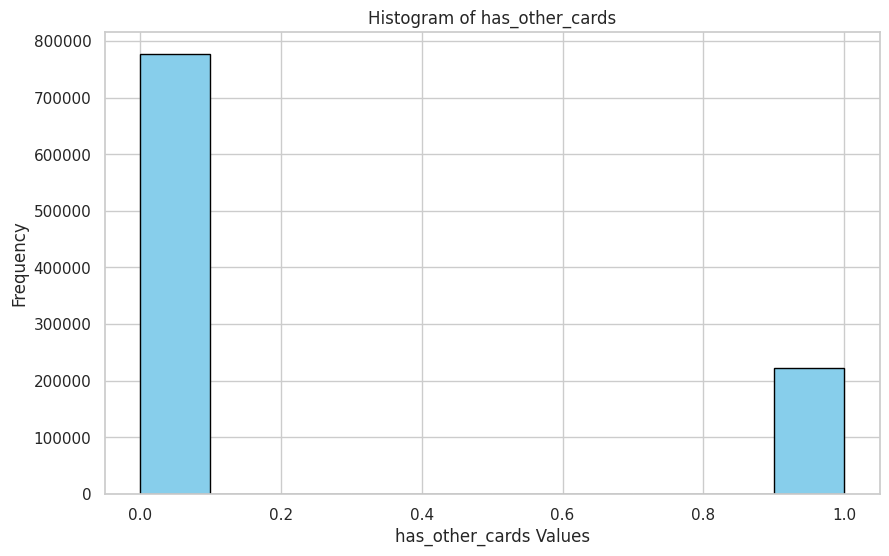

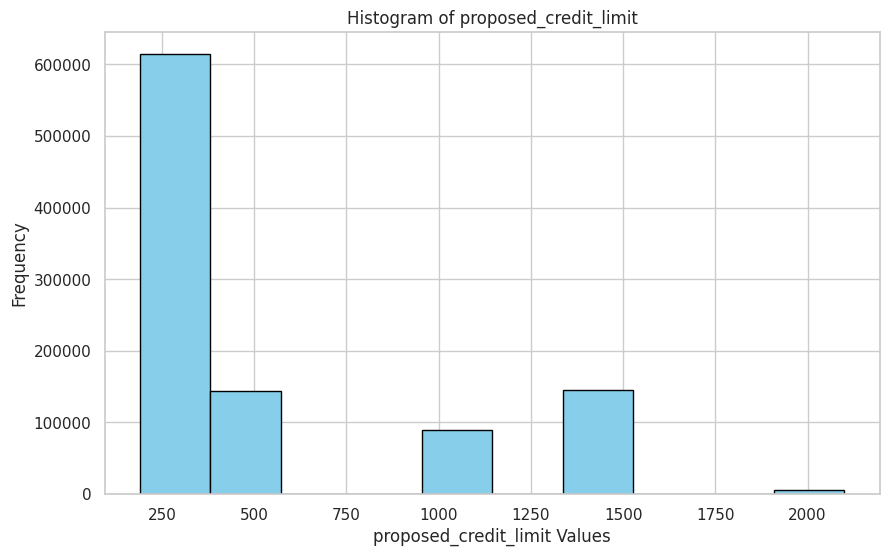

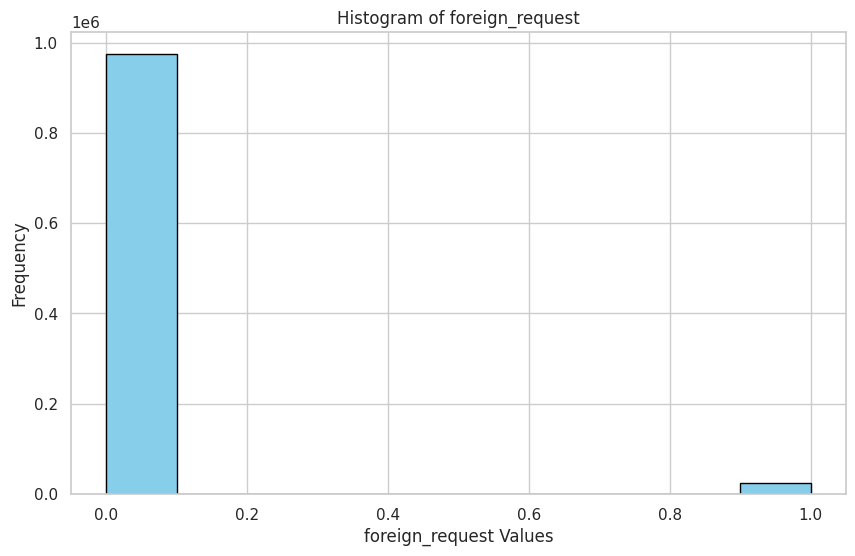

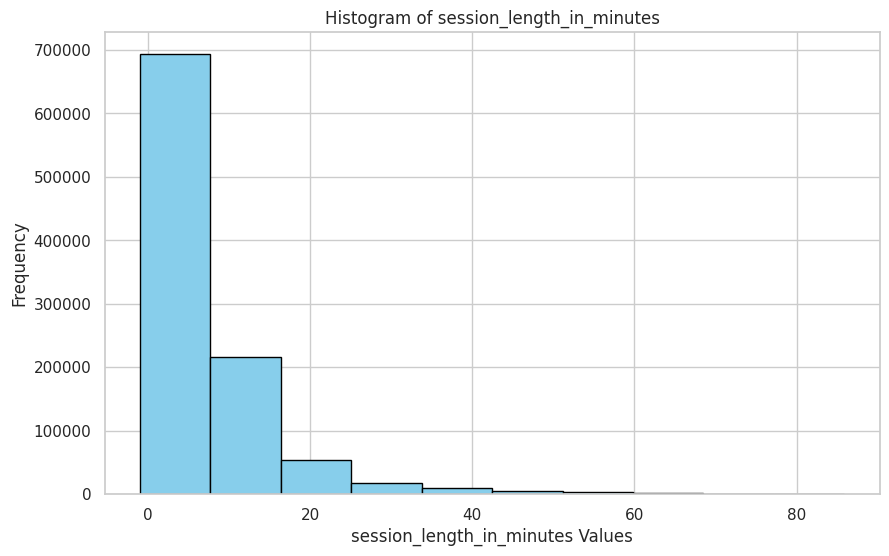

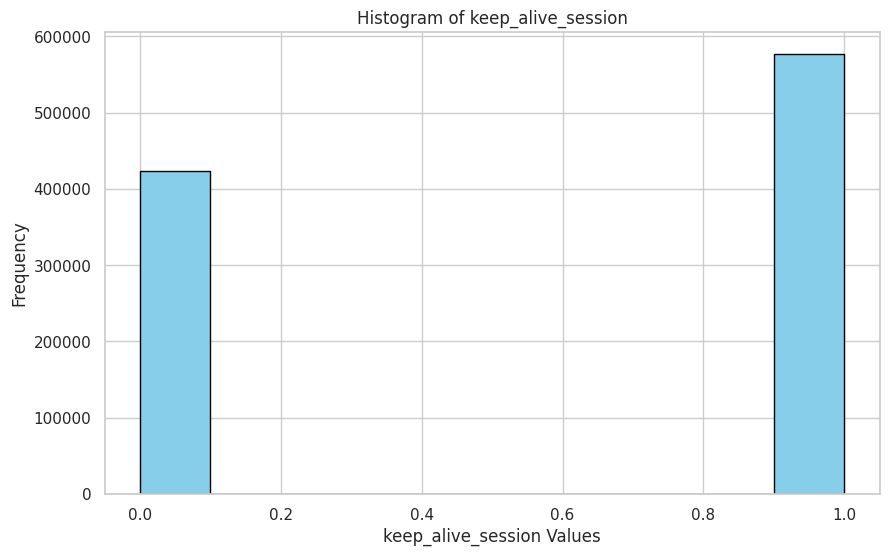

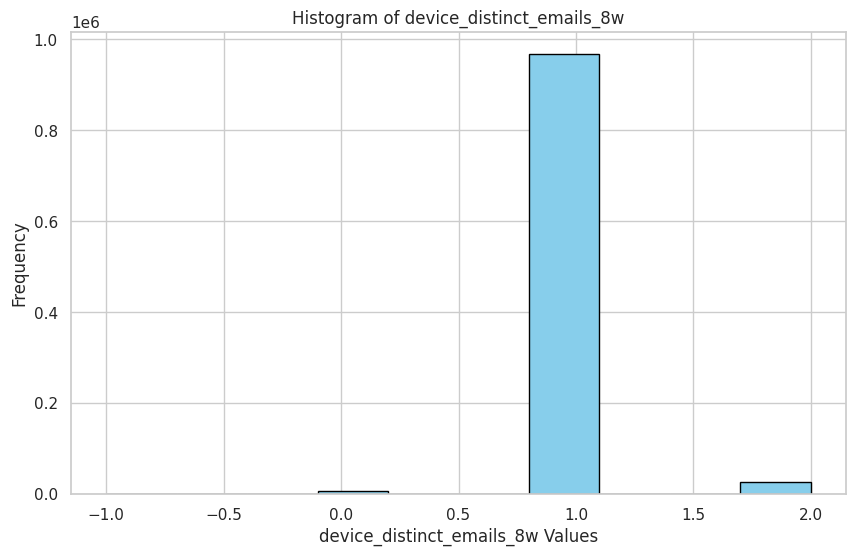

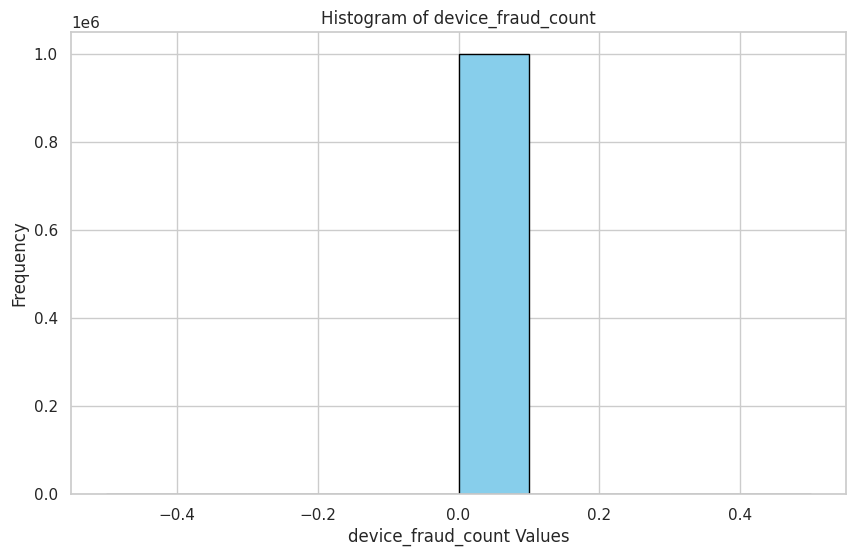

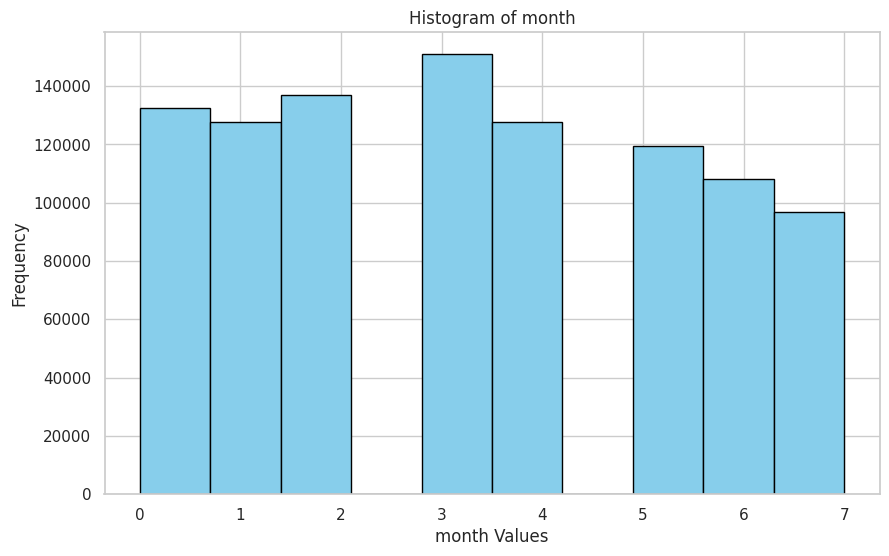

In [30]:
plt.figure(figsize=(10, 6))

# Lặp qua từng cột trong num_df
for col in num_df.columns:
    # Tạo một biểu đồ mới cho mỗi cột
    plt.figure(figsize=(10, 6))
    
    # Vẽ histogram cho mỗi cột
    plt.hist(num_df[col], color='skyblue', edgecolor='black')
    
    # Đặt tiêu đề và nhãn trục
    plt.title(f"Histogram of {col}")
    plt.xlabel(f"{col} Values")
    plt.ylabel("Frequency")
    
    # Hiển thị biểu đồ
    plt.show()

In [31]:
# Separate the target variable if needed
target_variable = 'fraud_bool'
features = df.drop(columns=[target_variable])


In [32]:
numerical_features = features.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = features.select_dtypes(include=['object', 'category']).columns.tolist()

In [33]:
# Function to print features without quotes
def print_features(feature_list):
    print(", ".join(feature_list))

print("Numerical Features:")
print_features(numerical_features)

print("\nCategorical Features:")
print_features(categorical_features)

Numerical Features:
income, name_email_similarity, prev_address_months_count, current_address_months_count, customer_age, days_since_request, intended_balcon_amount, zip_count_4w, velocity_6h, velocity_24h, velocity_4w, bank_branch_count_8w, date_of_birth_distinct_emails_4w, credit_risk_score, email_is_free, phone_home_valid, phone_mobile_valid, bank_months_count, has_other_cards, proposed_credit_limit, foreign_request, session_length_in_minutes, keep_alive_session, device_distinct_emails_8w, device_fraud_count, month

Categorical Features:
payment_type, employment_status, housing_status, source, device_os


### Data Pre-Processing

In [34]:
df_fraud = df[df['fraud_bool'] == 1]
df_non_fraud = df[df['fraud_bool'] == 0]

In [35]:
df_non_fraud_downsampled = resample(df_non_fraud,
                                    replace=False,  # sample without replacement
                                    n_samples=len(df_fraud),  # to match minority class
                                    random_state=42)  # for reproducibility

# Combine minority class with downsampled majority class
df_balanced = pd.concat([df_fraud, df_non_fraud_downsampled])

In [36]:
df_non_fraud_downsampled.shape

(11029, 32)

In [37]:
df_non_fraud_downsampled.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,employment_status,credit_risk_score,email_is_free,housing_status,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
518794,0,0.8,0.735925,104,10,30,0.030076,-1.480613,AB,2062,1664.244920,3839.597315,4962.294552,45,14,CA,91,1,BB,0,1,1,0,200.0,0,INTERNET,3.742273,other,1,1,0,3
567631,0,0.9,0.313330,-1,30,30,0.002789,-1.303670,AB,1498,7375.041588,5404.494837,5072.988221,25,11,CA,73,0,BC,0,1,1,0,200.0,0,INTERNET,3.669544,other,1,1,0,4
269688,0,0.1,0.129044,-1,238,20,0.013602,-1.027149,AB,1019,11545.580597,7142.127074,5767.843283,6,10,CA,47,0,BE,1,1,30,0,200.0,0,INTERNET,3.411296,linux,1,1,0,2
375838,0,0.9,0.071233,-1,65,30,0.005794,-0.877066,AD,1140,2928.116344,4557.353802,5638.310004,2021,9,CB,77,1,BC,0,1,1,1,200.0,0,INTERNET,5.310112,linux,1,1,0,2
558695,0,0.1,0.920019,62,13,30,0.018723,50.296179,AA,1103,3721.656126,2703.314684,4359.495202,2,4,CA,185,1,BB,1,0,-1,0,1500.0,0,INTERNET,20.368814,linux,1,1,0,4


In [38]:
df_balanced.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,employment_status,credit_risk_score,email_is_free,housing_status,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
43,1,0.9,0.570800,-1,157,60,0.005908,35.337538,AA,4079,8139.265753,4312.230612,6341.431598,2,17,CA,131,1,BA,1,1,30,0,1500.0,0,INTERNET,4.036394,windows,1,1,0,0
140,1,0.1,0.993219,-1,67,20,0.015331,92.120139,AA,1192,8330.727428,6708.346918,6709.436651,37,6,CA,79,1,BB,0,1,25,0,1500.0,0,INTERNET,12.928072,windows,0,1,0,0
284,1,0.8,0.794351,-1,376,60,17.925951,41.422110,AA,815,9747.407396,6902.019628,6467.154127,46,3,CC,196,1,BA,1,0,28,0,1500.0,0,INTERNET,2.550167,linux,0,1,0,0
314,1,0.7,0.090000,-1,58,50,0.004134,-1.244047,AD,4011,8036.901841,5794.624929,6333.335164,2,6,CA,177,1,BA,0,1,27,0,1500.0,0,INTERNET,3.500856,windows,0,1,0,0
561,1,0.9,0.998248,31,45,30,0.010165,33.067538,AA,525,6883.814598,3655.042385,4327.215795,16,12,CA,273,1,BA,0,1,1,1,2000.0,0,INTERNET,44.536211,windows,0,1,0,0


In [39]:
df_balanced.shape

(22058, 32)

In [40]:
# Trộn ngẫu nhiên lại toàn bộ dữ liệu và đặt lại chỉ số (index)
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [41]:
df_balanced.shape

(22058, 32)

In [43]:
# Define categorical and numerical features
categorical_features = ['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']
numerical_features = df_balanced.drop(columns=['fraud_bool', 'month'] + categorical_features).columns.tolist()

In [44]:
# Định nghĩa ColumnTransformer để chuẩn hóa dữ liệu
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),  # Chuẩn hóa các đặc trưng số
        ('cat', OneHotEncoder(sparse_output=False, drop='first'), categorical_features)  # Mã hóa one-hot cho các đặc trưng phân loại
    ]
)

In [45]:
train_data = df_balanced[df_balanced['month'].between(0, 5)]  # Lấy các tháng từ 0 đến 5 làm tập huấn luyện
test_data = df_balanced[df_balanced['month'].between(6, 7)]  # Lấy các tháng từ 6 đến 7 làm tập kiểm tra

In [46]:
# Loại bỏ cột "month" khỏi tập huấn luyện và tập kiểm tra
train_data = train_data.drop(columns=['month'])
test_data = test_data.drop(columns=['month'])

In [47]:
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

In [48]:
# Tách đặc trưng và biến mục tiêu
X_train = train_data.drop('fraud_bool', axis=1)  # Đặc trưng của tập huấn luyện
y_train = train_data['fraud_bool']  # Biến mục tiêu của tập huấn luyện
X_test = test_data.drop('fraud_bool', axis=1)  # Đặc trưng của tập kiểm tra
y_test = test_data['fraud_bool']  # Biến mục tiêu của tập kiểm tra

In [49]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [54]:
X_train_transformed.shape

(16934, 46)

In [55]:
X_test_transformed.shape

(5124, 46)

Algorithm: Logistic Regression
Logistic Regression Test Data Evaluation:
              precision    recall  f1-score   support

           0       0.72      0.84      0.77      2246
           1       0.86      0.74      0.80      2878

    accuracy                           0.79      5124
   macro avg       0.79      0.79      0.79      5124
weighted avg       0.80      0.79      0.79      5124

Algorithm: KNN
KNN Test Data Evaluation:
              precision    recall  f1-score   support

           0       0.69      0.70      0.69      2246
           1       0.76      0.75      0.76      2878

    accuracy                           0.73      5124
   macro avg       0.72      0.72      0.72      5124
weighted avg       0.73      0.73      0.73      5124

Algorithm: Gaussian Naive Bayes
Gaussian Naive Bayes Test Data Evaluation:
              precision    recall  f1-score   support

           0       0.79      0.52      0.63      2246
           1       0.71      0.89      0.79     

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


Neural Network Test Data Evaluation:
              precision    recall  f1-score   support

           0       0.73      0.78      0.76      2246
           1       0.82      0.77      0.80      2878

    accuracy                           0.78      5124
   macro avg       0.77      0.78      0.78      5124
weighted avg       0.78      0.78      0.78      5124

Algorithm: LightGBM
[LightGBM] [Info] Number of positive: 8151, number of negative: 8783
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3199
[LightGBM] [Info] Number of data points in the train set: 16934, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.481339 -> initscore=-0.074677
[LightGBM] [Info] Start training from score -0.074677
LightGBM Test Data Evaluation:
              precision    re

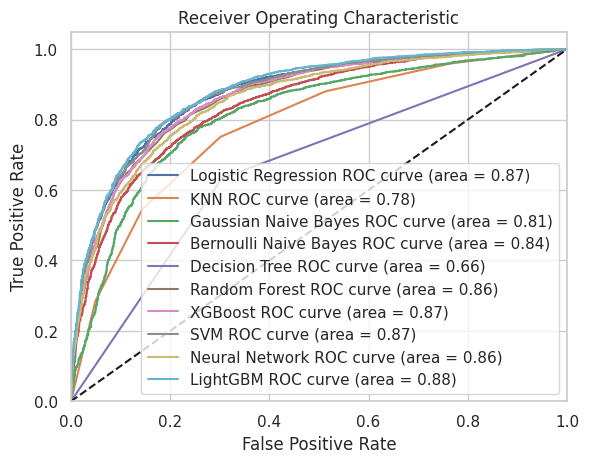

In [58]:
# Define models
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "Gaussian Naive Bayes": GaussianNB(),
    "Bernoulli Naive Bayes": BernoulliNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    "SVM": SVC(probability=True, random_state=42),
    "Neural Network": MLPClassifier(random_state=42),
    "LightGBM": LGBMClassifier(random_state=42)
    
}

# Train and evaluate models
results = []
roc_curves = {}

# Normalization placeholders
acc_list = []
roc_auc_list = []
log_loss_list = []
mse_list = []
time_list = []

for model_name, model in models.items():
    print(f"Algorithm: {model_name}")
    start_time = time.time()
    model.fit(X_train_transformed, y_train)
    train_time = time.time() - start_time
    
    start_time = time.time()
    y_test_pred = model.predict(X_test_transformed)
    prediction_time = time.time() - start_time

    y_test_prob = model.predict_proba(X_test_transformed)[:, 1] if hasattr(model, 'predict_proba') else None

    print(f"{model_name} Test Data Evaluation:\n{classification_report(y_test, y_test_pred)}")
    accuracy = accuracy_score(y_test, y_test_pred)
    mse = mean_squared_error(y_test, y_test_pred)
    
    if y_test_prob is not None:
        roc_auc = roc_auc_score(y_test, y_test_prob)
        logloss = log_loss(y_test, y_test_prob)
        
        fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
        roc_curves[model_name] = (fpr, tpr, roc_auc)
    else:
        roc_auc = None
        logloss = None

    total_time = train_time + prediction_time
    
    # Append metrics to the lists for normalization
    acc_list.append(accuracy)
    roc_auc_list.append(roc_auc)
    log_loss_list.append(logloss)
    mse_list.append(mse)
    time_list.append(total_time)
    
    results.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "ROC-AUC Score": roc_auc,
        "Log Loss": logloss,
        "Mean Squared Error": mse,
        "Training Time (s)": train_time,
        "Prediction Time (s)": prediction_time,
        "Total Time (s)": total_time
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Normalization
results_df['Normalized Accuracy'] = (results_df['Accuracy'] - min(acc_list)) / (max(acc_list) - min(acc_list))
results_df['Normalized ROC-AUC Score'] = (results_df['ROC-AUC Score'] - min(roc_auc_list)) / (max(roc_auc_list) - min(roc_auc_list))
results_df['Normalized Log Loss'] = (max(log_loss_list) - results_df['Log Loss']) / (max(log_loss_list) - min(log_loss_list))
results_df['Normalized Mean Squared Error'] = (max(mse_list) - results_df['Mean Squared Error']) / (max(mse_list) - min(mse_list))
results_df['Normalized Total Time'] = (max(time_list) - results_df['Total Time (s)']) / (max(time_list) - min(time_list))

# Aggregate the normalized scores into a single score
results_df['Aggregate Score'] = (results_df['Normalized Accuracy'] + results_df['Normalized ROC-AUC Score'] +
                                 results_df['Normalized Log Loss'] + results_df['Normalized Mean Squared Error'] +
                                 results_df['Normalized Total Time']) / 5

# Rank the models based on the aggregate score
results_df['Rank'] = results_df['Aggregate Score'].rank(ascending=False)

# Sort the DataFrame by rank
results_df = results_df.sort_values(by='Rank')

# Add the model names to the ranks
ranked_results = results_df[['Model', 'Accuracy', 'ROC-AUC Score', 'Log Loss', 'Mean Squared Error', 'Training Time (s)', 'Prediction Time (s)', 'Total Time (s)', 'Aggregate Score']]

# Print the final DataFrame with ranks and model names
print(ranked_results)

# Add the model names to the ranks
ranked_results = results_df[['Rank', 'Model']].sort_values(by='Rank')

# Print the final DataFrame with ranks and model names
print(ranked_results)

# Plot all ROC curves in one plot
plt.figure()
for model_name, (fpr, tpr, roc_auc) in roc_curves.items():
    plt.plot(fpr, tpr, label=f'{model_name} ROC curve (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()